In this notebook, we wil use tooks in the analytics engine to calculate HDDs on census tracts.

In [1]:
from climakitae.new_core.user_interface import ClimateData
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from climakitae.new_core.data_access.data_access import DataCatalog
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.tools.derived_variables import compute_hdd_hdd

cd = ClimateData()

catalog = DataCatalog()
census_tracts = catalog.boundaries._ca_census_tracts

#select an arbitraty sample of 10 census tracts
my_tracts = census_tracts.iloc[20:30]

ImportError: cannot import name 'compute_hdd_hdd' from 'climakitae.tools.derived_variables' (/Users/work/Code/climakitae/climakitae/tools/derived_variables.py)

In [ ]:
## basemap plotting magic from https://github.com/Eagle-Rock-Analytics/the-shoppe/blob/069d8cb3e4dae1bd4e2f23b282d3b17ced82d9ca/src/plotting.py

from urllib.request import Request, urlopen
import io
import cartopy.io.img_tiles as cimgt
from PIL import Image


def image_spoof_cached(tile_xyz: tuple, tile_url: str, desired_format: str):
    """
    Cached version of image_spoof. Uses tile XYZ, URL, and desired format as the cache key.
    """
    req = Request(tile_url)
    req.add_header("User-agent", "Anaconda 3")
    fh = urlopen(req)
    im_data = io.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)
    img = img.convert(desired_format)
    return img

def image_spoof(self, tile):
    """
    This function reformats web requests from OSM for cartopy and caches them to avoid redownloading.
    """
    tile_url = self._image_url(tile)
    tile_key = (tile[0], tile[1], tile[2])  # tile = (z, x, y)
    img = image_spoof_cached(tile_key, tile_url, self.desired_tile_form)
    return img, self.tileextent(tile), "lower"

In [ ]:
list(my_tracts['GEOID'].values)

['06073021900',
 '06073020026',
 '06073020028',
 '06073013421',
 '06029005402',
 '06071008402',
 '06033000502',
 '06071003506',
 '06073000400',
 '06053000101']

In [ ]:
fig = plt.figure(figsize=(8, 6))

basemap_style = "satellite"  # options: "map", "satellite", None

if basemap_style == "map":
    cimgt.OSM.get_image = image_spoof
    tiler = cimgt.OSM()
elif basemap_style == "satellite":
    cimgt.QuadtreeTiles.get_image = image_spoof
    tiler = cimgt.QuadtreeTiles()
else:
    tiler = None

ax = fig.add_subplot(111, projection=tiler.crs)

if tiler:
    #ax = fig.add_subplot(1, projection=tiler.crs)  # Create subplot with map projection
    center_lon = -110
    center_lat = 33
    ax.add_image(tiler, 6, zorder=2, alpha=0.6)


# Superimpose census tract boundaries
my_tracts.boundary.plot(
    ax=ax,
    edgecolor='#39FF14',
    linewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5)


plt.title("Sample Census Tracts", fontsize=16)


KeyboardInterrupt: 

In [6]:
tracts_wrf = (cd.catalog("cadcat")
        .activity_id("WRF")
        .variable("t2")
        .table_id("day")
        .grid_label("d03")
        .processes(
            {
                "warming_level": {
                    "warming_levels": [0.8,2.0],
                },
                "clip": {"boundaries": list(my_tracts['GEOID'].values), "separated": True},
                "convert_units": "degF"
            }
        )
        .get()
    )

2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Activity ID set to: WRF
2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Processes set: 3 operations configured
2025-12-30 12:10:17 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'WRF', 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'station_id': UNSET, 'network_id': UNSET, 'processes': {'warming_level': {'warming_levels': [0.8, 2.0]}, 'clip': {'boundaries': ['06073021900', '0607302002

In [7]:
tracts_wrf

<xarray.Dataset> Size: 1GB
Dimensions:            (census_tract: 10, sim: 5, warming_level: 2,
                        time_delta: 10950, y: 20, x: 17)
Coordinates: (12/13)
  * warming_level      (warming_level) float64 16B 0.8 2.0
  * x                  (x) float64 136B -4.191e+06 -4.188e+06 ... -3.975e+06
  * y                  (y) float64 160B 6.559e+05 6.589e+05 ... 1.532e+06
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
  * sim                (sim) object 40B 'WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p...
    lakemask           (census_tract, y, x) float32 14kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    ...                 ...
    lat                (census_tract, y, x) float32 14kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    lon                (census_tract, y, x) float32 14kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    simulation         <U39 156B 'WRF.UCLA.MIROC6.ssp370.day.d03.r1i1p1f1'
    centered_year      (warming_level) int64 16B 2012 2053
    Lambert_Conformal  int64 8B 0
  * census_tract       (census_tract) <U11 440B '06073021900' ... '06053000101'
Data variables:
    t2                 (census_tract, sim, warming_level, time_delta, y, x) float32 1GB dask.array<chunksize=(1, 1, 1, 3546, 1, 1), meta=np.ndarray>
Attributes: (12/121)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM-TOP_GRID_DIMENSION:        40
    BOTTOM-TOP_PATCH_END_STAG:        40
    ...                               ...
    clip:                             Process 'clip' applied to the data. Sep...
    convert_units:                    Process 'convert_units' applied to the ...
    update_attributes:                Process 'update_attributes' applied to ...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    warming_level_simple:             Process 'warming_level_simple' applied ...

In [8]:
tract_median = tracts_wrf.median(['x','y']).t2
#rename so this works nicely with the cdd/hdd function
tract_median = tract_median.rename("Air Temperature at 2m")

In [ ]:
hdd, cdd = compute_hdd_cdd(tract_median, hdd_threshold=65, hdd_threshold=65) # Set for all data within selected DFZ zone

In [ ]:
hdd = hdd.compute()
hdd = hdd.compute()

In [37]:
# calculate annual average total hdd/hdd
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"]).mean('year')
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"]).mean('year')

In [38]:
hdd_annual = hdd_annual.compute()
hdd_annual = hdd_annual.compute()


In [ ]:
# select only four models, excluding EC-Earth3-Veg with missing reference warming level

hdd_annual = cdd_annual.sel(sim = ['WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1'])

hdd_annual = hdd_annual.sel(sim = ['WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1'])

In [40]:
cdd_annual_mmmean = cdd_annual.mean('sim')
hdd_annual_mmmean = hdd_annual.mean('sim')

In [12]:
# transform into dataframe for export
cdd_df = cdd_annual.to_dataframe()

In [19]:
cdd_df = cdd_df.reset_index()

In [25]:
cdd_annual.to_dataframe().to_csv("test.csv")

In [24]:
pivot_df = cdd_df.pivot(
            index='census_tract', 
            columns=['warming_level', 'sim'], 
            values='Cooling Degree Days'
        )

In [27]:
pivot_df.to_csv("sample_census_tract_data.csv")

In [ ]:
pivot_df.columns = [f'{sim} - {warming_level}' for sim, warming_level in pivot_df.columns]

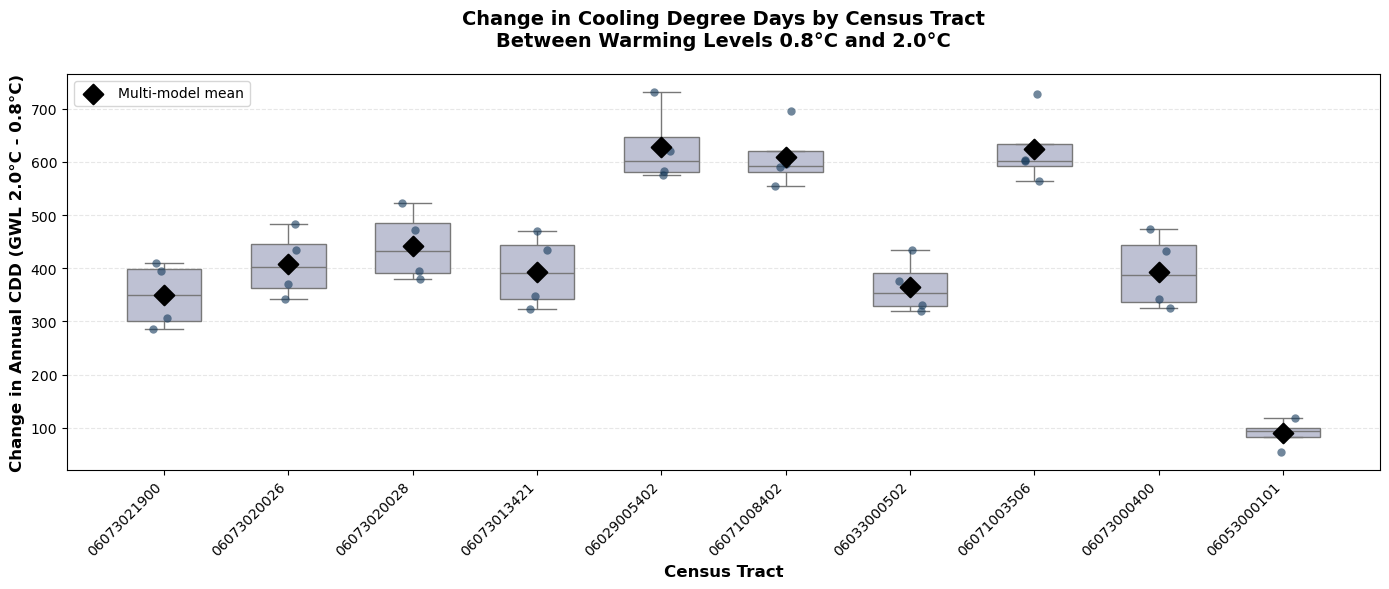


Summary Statistics for CDD Change by Census Tract:
                    mean        std         min         max
census_tract                                               
06029005402   627.679993  72.150002  575.880005  732.000000
06033000502   365.500000  52.509998  318.959991  434.970001
06053000101    89.639999  26.120001   54.689999  118.000000
06071003506   624.219971  70.800003  564.919983  727.039978
06071008402   608.969971  60.160000  554.520020  694.919983
06073000400   393.329987  72.010002  324.329987  474.290009
06073013421   393.730011  69.589996  322.820007  469.500000
06073020026   407.200012  63.270000  341.820007  482.480011
06073020028   442.269989  67.220001  379.980011  523.309998
06073021900   348.910004  62.490002  284.890015  409.760010


In [33]:
import seaborn as sns
import pandas as pd

# Calculate the change (delta) in CDD between warming levels
cdd_change = cdd_annual.sel(warming_level=2.0) - cdd_annual.sel(warming_level=0.8)

# Convert to DataFrame for easier plotting
cdd_change_df = cdd_change.to_dataframe(name='CDD_change').reset_index()

# Calculate multi-model mean for each census tract
cdd_change_mean = cdd_change.mean('sim').to_dataframe(name='CDD_change_mean').reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot
sns.boxplot(data=cdd_change_df, x='census_tract', y='CDD_change', 
            color='#BBBFD6', ax=ax, width=0.6, fliersize=0)

# Overlay individual simulation points
sns.stripplot(data=cdd_change_df, x='census_tract', y='CDD_change', 
              color='#13385A', alpha=0.6, size=6, ax=ax, label=None)

# Overlay multi-model mean
ax.scatter(range(len(cdd_change_mean)), cdd_change_mean['CDD_change_mean'], 
           color='black', s=100, marker='D', zorder=5, label='Multi-model mean', 
           edgecolors='black', linewidths=1.5)

# Customize plot
ax.set_xlabel('Census Tract', fontsize=12, fontweight='bold')
ax.set_ylabel('Change in Annual CDD (GWL 2.0°C - 0.8°C)', fontsize=12, fontweight='bold')
ax.set_title('Change in Cooling Degree Days by Census Tract\nBetween Warming Levels 0.8°C and 2.0°C', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for CDD Change by Census Tract:")
print("="*70)
summary = cdd_change_df.groupby('census_tract')['CDD_change'].agg(['mean', 'std', 'min', 'max'])
print(summary.round(2))

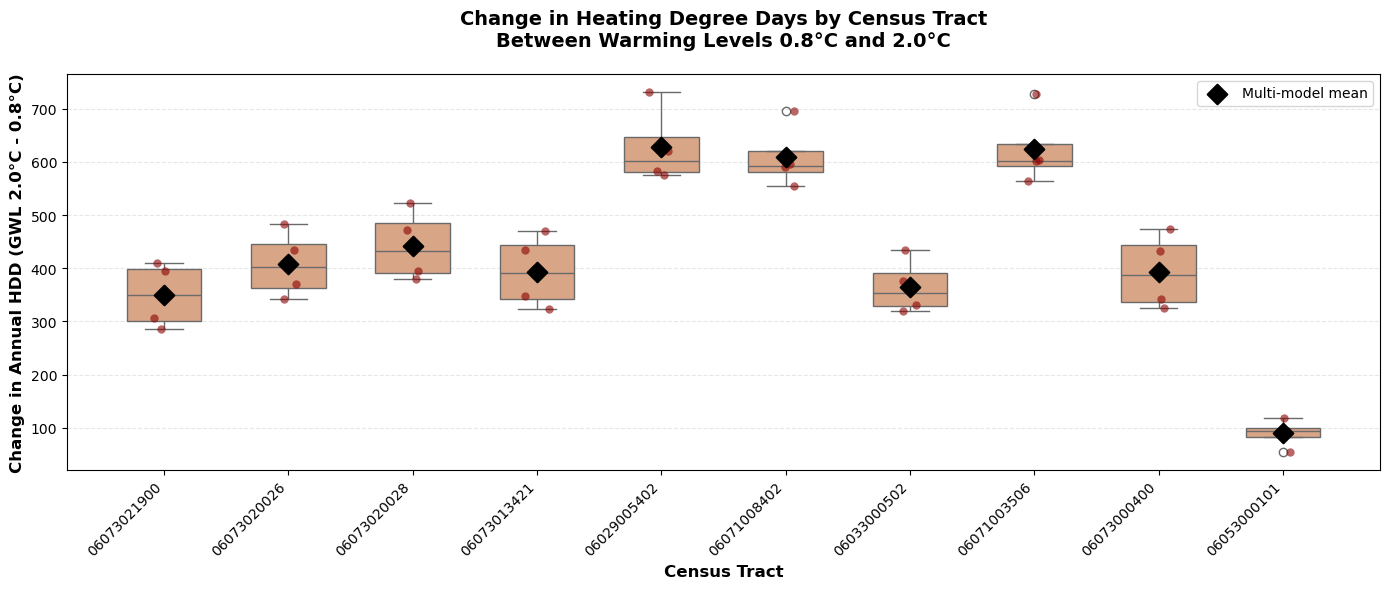


Summary Statistics for HDD Change by Census Tract:
                    mean        std         min         max
census_tract                                               
06029005402   627.679993  72.150002  575.880005  732.000000
06033000502   365.500000  52.509998  318.959991  434.970001
06053000101    89.639999  26.120001   54.689999  118.000000
06071003506   624.219971  70.800003  564.919983  727.039978
06071008402   608.969971  60.160000  554.520020  694.919983
06073000400   393.329987  72.010002  324.329987  474.290009
06073013421   393.730011  69.589996  322.820007  469.500000
06073020026   407.200012  63.270000  341.820007  482.480011
06073020028   442.269989  67.220001  379.980011  523.309998
06073021900   348.910004  62.490002  284.890015  409.760010


In [42]:
# Calculate the change (delta) in HDD between warming levels
hdd_change = hdd_annual.sel(warming_level=2.0) - hdd_annual.sel(warming_level=0.8)

# Convert to DataFrame for easier plotting
hdd_change_df = hdd_change.to_dataframe(name='HDD_change').reset_index()

# Calculate multi-model mean for each census tract
hdd_change_mean = hdd_change.mean('sim').to_dataframe(name='HDD_change_mean').reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot
sns.boxplot(data=hdd_change_df, x='census_tract', y='HDD_change', 
            color='#E7A279', ax=ax, width=0.6)

# Overlay individual simulation points
sns.stripplot(data=hdd_change_df, x='census_tract', y='HDD_change', 
              color='darkred', alpha=0.6, size=6, ax=ax, label=None)

# Overlay multi-model mean
ax.scatter(range(len(hdd_change_mean)), hdd_change_mean['HDD_change_mean'], 
           color='black', s=100, marker='D', zorder=5, label='Multi-model mean', 
           edgecolors='black', linewidths=1.5)

# Customize plot
ax.set_xlabel('Census Tract', fontsize=12, fontweight='bold')
ax.set_ylabel('Change in Annual HDD (GWL 2.0°C - 0.8°C)', fontsize=12, fontweight='bold')
ax.set_title('Change in Heating Degree Days by Census Tract\nBetween Warming Levels 0.8°C and 2.0°C', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for HDD Change by Census Tract:")
print("="*70)
summary = hdd_change_df.groupby('census_tract')['HDD_change'].agg(['mean', 'std', 'min', 'max'])
print(summary.round(2))

In [23]:
# calculate annual average total hdd/hdd
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"])
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"])

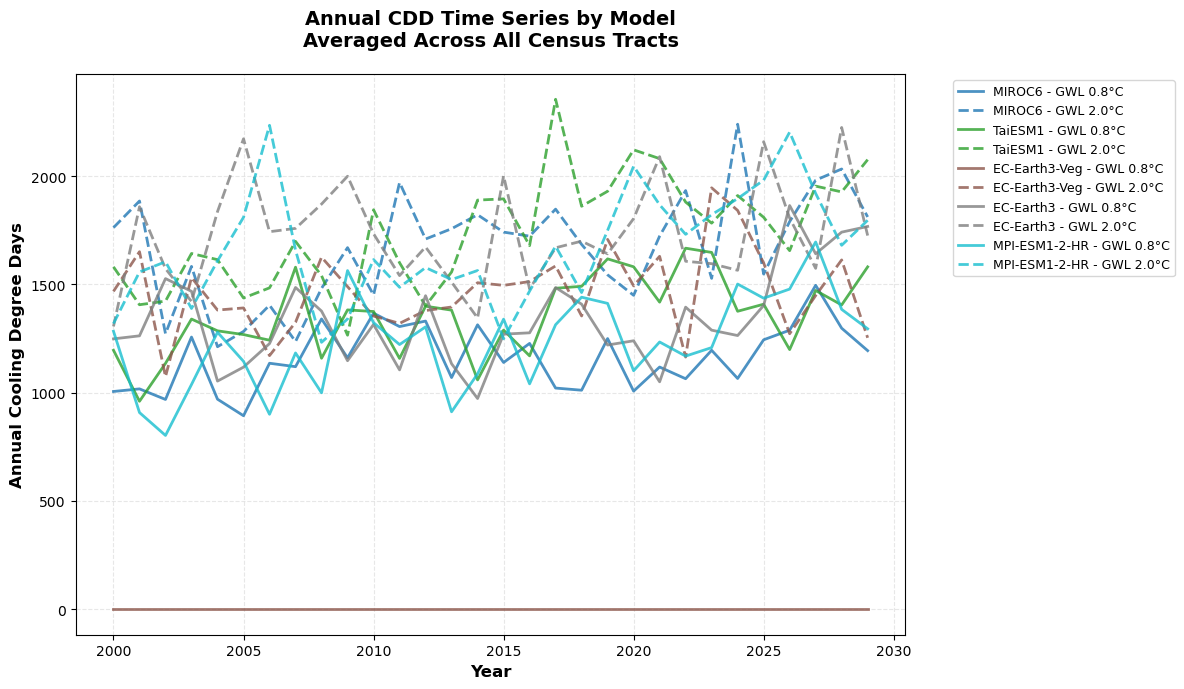

In [24]:
# Create annual CDD time series (without averaging over years)
cdd_annual_ts = add_dummy_time_to_wl(cdd).squeeze().groupby("time.year").sum(["time"])

# Average across all census tracts for cleaner visualization
cdd_annual_ts_avg = cdd_annual_ts.mean('census_tract')

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors for each simulation
colors = plt.cm.tab10(np.linspace(0, 1, len(cdd_annual_ts_avg.sim)))

# Plot each simulation for both warming levels
for i, sim in enumerate(cdd_annual_ts_avg.sim.values):
    # Plot GWL 0.8°C (solid line)
    cdd_annual_ts_avg.sel(sim=sim, warming_level=0.8).plot(
        ax=ax, label=f'{sim.split("_")[2]} - GWL 0.8°C', 
        color=colors[i], linestyle='-', linewidth=2, alpha=0.8
    )
    
    # Plot GWL 2.0°C (dashed line)
    cdd_annual_ts_avg.sel(sim=sim, warming_level=2.0).plot(
        ax=ax, label=f'{sim.split("_")[2]} - GWL 2.0°C', 
        color=colors[i], linestyle='--', linewidth=2, alpha=0.8
    )

# Customize plot
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Annual Cooling Degree Days', fontsize=12, fontweight='bold')
ax.set_title('Annual CDD Time Series by Model\nAveraged Across All Census Tracts', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()